## Import modules and specify model

In [6]:
!source activate /home/gilbee3/anaconda3/envs/akita
import sys
filename='/dors/capra_lab/users/erin/RotationProject_Akita/scripts/basenji/basenji'
sys.path.append(os.path.dirname(filename))

In [7]:
import os
import json
import subprocess
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

import tensorflow as tf
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()

import numpy as np
np.random.seed(1337)
import pandas as pd
import pysam
import matplotlib as mpl
import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag

from basenji import dataset, dna_io, seqnn
from matplotlib.pyplot import xticks, yticks
from scipy import stats
from multiprocessing import  Pool

import warnings
from itertools import chain


1.15.0


In [8]:
### load params, specify model ###

model_dir = '../scripts/basenji/manuscripts/akita/'
params_file = model_dir+'params.json'
model_file  = model_dir+'model_best.h5'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

### restore model ###
# note: run %%bash get_model.sh 
# if you have not already downloaded the model
seqnn_model.restore(model_file)
print('successfully loaded')

### names of targets ###
data_dir =   '../scripts/basenji/manuscripts/akita/data/'

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict     = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

target_length1_cropped = target_length1 - 2*target_crop
print('flattened representation length:', target_length) 
print('symmetrix matrix size:', '('+str(target_length1_cropped)+','+str(target_length1_cropped)+')')


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1048576, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1048576, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1048576, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1048576, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

successfully loaded
flattened representation length: 99681
symmetrix matrix size: (448,448)


In [19]:
### for converting from flattened upper-triangluar vector to symmetric matrix  ###

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T



## Functions to extract files and run predictions

In [14]:


def find_inFileLoc(indiv, chrm):
    if (indiv == "vindija") | (indiv == "altai") | (indiv == "denisova") | (indiv == "chagyrskaya"):
        in_file_loc = '/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/%s/%s%s_hg19_masked.fa' % (indiv,chrm,indiv)
    elif os.path.exists('/dors/capra_lab/users/erin/RotationProject_Akita/data/genomes/1KG/%s/%s_%s_hg19_full.fa' % (indiv,chrm,indiv.split("_")[3])):
        in_file_loc = '/dors/capra_lab/users/erin/RotationProject_Akita/data/genomes/1KG/%s/%s_%s_hg19_full.fa' % (indiv,chrm,indiv.split("_")[3])
    else:
        in_file_loc = '/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/1KG.individuals/%s/%s_%s_hg19_full.fa' % (indiv,chrm,indiv.split("_")[3])
    return in_file_loc

def runAkitaPreds(seq):
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length')
    seq_1hot = dna_io.dna_1hot(seq)
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))
    return test_pred_from_seq

class extractFastaRunAkita:
    def __init__(self, indiv, chrm, start_loc):

        #find fasta file locations
        in_file_loc_indiv = find_inFileLoc(indiv, chrm)
        indiv_fasta_open = pysam.Fastafile(in_file_loc_indiv)
        mask_fasta_open = pysam.Fastafile('/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/masked_hg19_reference/%s_hg19_archaic.masked.fa' % chrm) #for the masked
        human19_fasta_open = pysam.Fastafile('/dors/capra_lab/data/dna/human/hg19/%s.fa' % chrm)

        #extract sequences
        indiv_seq = indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
        masked_seq = mask_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper() #for the masked 
        human19_seq = human19_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()

        # important harmonization step! then run predictions on the harmonized sequence
        indiv_fillMissing_seq = "".join([r if m == "N" else r if s == "N" else s for r, m, s in zip(human19_seq, masked_seq, indiv_seq)])
        self.seq = indiv_fillMissing_seq
        indiv_pred  = runAkitaPreds(indiv_fillMissing_seq)
        indiv_pred_hff = indiv_pred[:,:,0][0] # save only hff
        self.pred = indiv_pred_hff
        #return(indiv_pred_hff)

## Example

In [31]:
chrm = 'chr22'
start = 45613056
afr_seq = extractFastaRunAkita('AFR_MSL_female_HG03212',chrm,start).seq
eur_seq = extractFastaRunAkita('EUR_TSI_female_NA20797',chrm,start).seq
afr_pred = extractFastaRunAkita('AFR_MSL_female_HG03212',chrm,start).pred
eur_pred = extractFastaRunAkita('EUR_TSI_female_NA20797',chrm,start).pred

afr_mat = from_upper_triu(afr_pred, target_length1_cropped, hic_diags)
eur_mat = from_upper_triu(eur_pred, target_length1_cropped, hic_diags)


stats.spearmanr(afr_pred, eur_pred)
np.mean(np.square(afr_pred - eur_pred))

SpearmanrResult(correlation=0.9995619868852842, pvalue=0.0)

0.00019916096

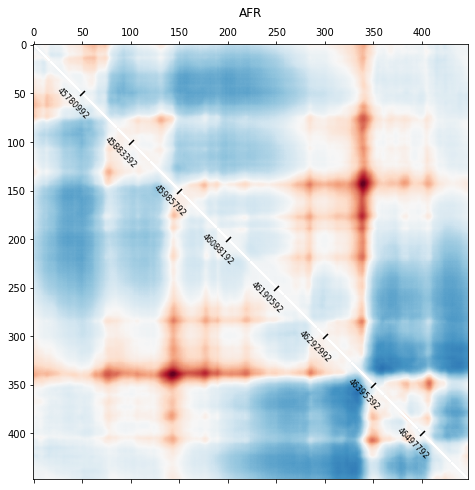

<Figure size 576x144 with 0 Axes>

In [34]:
_ = plt.figure(figsize=(8,8))
im = plt.matshow(afr_mat, fignum=False, cmap= 'RdBu_r', vmax=2, vmin=-2)

t = mpl.markers.MarkerStyle(marker='|')
t._transform = t.get_transform().rotate_deg(-45)
plt.scatter(x=np.arange(50,450,50),y=np.arange(50,450,50),marker = t,color='k',s=50)
for i in np.arange(50,450,50):
    _ = plt.text(i - 10, i+10, str(start+((32+i)*2048)), horizontalalignment='center', verticalalignment='center', rotation=-45,fontsize=8)
_ = plt.title('AFR')
plt.show()
_ = plt.figure(figsize=(8,2))

